In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf

os.chdir(os.path.join('..','data'))
raw_df = pd.read_csv('mj-clean.csv',parse_dates=[5])
df = raw_df[raw_df['date']<np.datetime64('2014-05-31')]
start_date = min(df['date'])
year = np.datetime64(1,'Y')
df['year'] = ((df['date'] - start_date)).astype('timedelta64[D]')/365
# parse the date otherwise the date will be interpreted as object

exercise 12.1
-----

In [51]:
groups = df.groupby('quality')
dailies = {}
for name,group in groups:
    day = group[['date','ppg','year']].groupby('date').aggregate(np.mean)
    day['year2'] = day['year']**2
    dailies[name] = day

In [4]:
def fit_quadratic(df):
    formula = 'ppg~year+year2'
    result = smf.ols(formula,data=df).fit()
    return result

linear = 'ppg~year'
linear_result =smf.ols(linear,data=dailies['high']).fit()
quadratic = fit_quadratic(dailies['high'])
quadratic.params

Intercept    13.697994
year         -1.116387
year2         0.113053
dtype: float64

In [5]:
quadratic.rsquared,linear_result.rsquared

(0.45534289626070035, 0.4440776245351705)

The quadratic is slighly better result than the linear one.

In [6]:
quadratic.pvalues

Intercept    0.000000e+00
year         5.858422e-38
year2        4.820300e-07
dtype: float64

Text(0.5,1,'Quadratic Model')

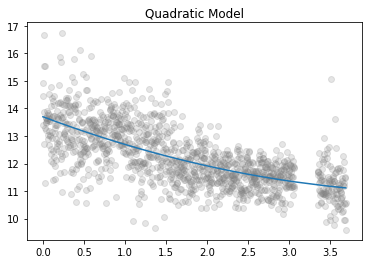

In [7]:
plt.scatter(dailies['high']['year'],dailies['high']['ppg'],color='gray',alpha=0.2)
predictions = quadratic.predict()
plt.plot(dailies['high']['year'],predictions)
plt.title('Quadratic Model')

In [54]:
def SimulateLinearModels(df,iters=100):
    results = []
    fake_df= df.copy()
    result = fit_quadratic(df)
    resid = result.resid
    for _ in range(iters):
        fake_data= result.fittedvalues + np.random.choice(resid,replace=True,size=len(df))
        fake_df['ppg'] = fake_data
        fake_result = fit_quadratic(fake_df)
        results.append(fake_result)
    return results


def generatePredictions(results,series,iters=100,is_resid=True):
    predictions = []
    years = np.linspace(0,5,num=len(series))
    d = dict(year=years,year2=years**2)
    predict_df = pd.DataFrame(d)
    for result in results:
        r = result.predict(predict_df)
        if is_resid:
            r += np.random.choice(result.resid,replace=True,size=len(series))
        predictions.append(r)
        
    return np.array(predictions)

series = dailies['high']

results=SimulateLinearModels(series)


years = np.linspace(0,5,num=len(series))
predictions=generatePredictions(results,series)
predictions2=generatePredictions(results,series,is_resid=False)
np.shape(predictions)

(100, 1241)

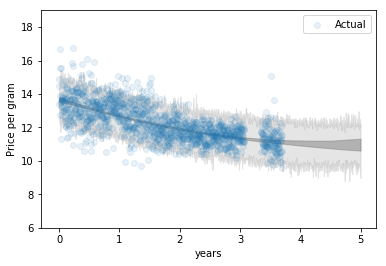

In [55]:
def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

def percentile(p,series):
    series, cdfs = compute_cdf(series)
    if p < min(cdfs):
        p = min(cdfs)
    return series[cdfs.index(max([cdf for cdf in cdfs if cdf <=p]))]

def plot_predictions(predictions,years,CI=90,alpha=0.2):
    low_ci = (100-CI)/(2*100)
    high_ci = low_ci+CI/100
    lows,highs = [],[]
    for i in range(np.shape(predictions)[1]):
        data = predictions[:,i]
        lows.append(percentile(low_ci,data))
        highs.append(percentile(high_ci,data))
    plt.fill_between(years,lows,highs,color='gray',alpha=alpha)
    plt.ylim(6,19)
    
#plot_predictions(predictions,years)
plot_predictions(predictions,years,alpha=0.2)
plot_predictions(predictions2,years,alpha=0.5)
plt.scatter(dailies['high']['year'],dailies['high']['ppg'],alpha=0.1,label='Actual')
plt.xlabel('years')
plt.ylabel('Price per gram')
plt.legend()

exercise 12.2
-----

In [56]:
# hypothesis testing for serial correlation
series = dailies['high']['ppg']

def serialCorrelation(series,nlag):
    past = series.shift(nlag)[nlag:].values
    future = series[nlag:]
    
    return stats.pearsonr(past,future)[0]

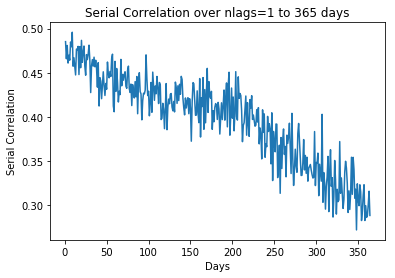

In [57]:
def plot_corr_over_nlags():
    correlations = []
    for i in range(1,365):
        correlations.append(serialCorrelation(series,nlag=i))
    plt.plot(range(1,365),correlations)
    plt.title('Serial Correlation over nlags=1 to 365 days')
    plt.xlabel('Days')
    plt.ylabel('Serial Correlation')
    
plot_corr_over_nlags()  

From the observation, we can say that the future prices are affected more by the daily prices than yearly.

In [65]:
series= dailies['high']['ppg']
def serialCorrelationTest(series,iters=101,nlag=1):
    correlations=[]
    actual = serialCorrelation(series,nlag=nlag)
    for _ in range(iters):
        sample = pd.Series(np.random.choice(series,replace=True,size=len(series)))
        correlations.append(serialCorrelation(sample,nlag=nlag))
    
    p_value = len([x for x in correlations if x>actual])/iters
    return p_value,actual

serialCorrelationTest(series)

(0.0, 0.485229376194738)

The serial correlation for high quality weed price is significant

In [68]:
# test for the residuals of the linear model
linear_resid = linear_result.resid
quad_resid = quadratic.resid

serialCorrelationTest(linear_resid),serialCorrelationTest(quad_resid)

((0.009900990099009901, 0.07570473767506253),
 (0.019801980198019802, 0.056073081612899096))

The serial correlation for residuals for both the models is significant though there is very less correlation